<a href="https://colab.research.google.com/github/Koelgeetkaur26/Probing-_Adaptive-Forgetting-in-a-Meta-RL-Agent/blob/main/Adaptive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


### PART 0: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression

In [2]:

# ### PART 1: CODE FROM THE ORIGINAL PROJECT WHICH IS REQUIRED FOR TRAINING ###
# We use the same RestlessBandit, MetaRLAgent, and training function.

class RestlessBandit:
    def __init__(self, n_trials_per_episode=100, drift_std=0.025):
        self.n_trials_per_episode = n_trials_per_episode
        self.drift_std = drift_std
        self.reward_probs = np.array([0.5, 0.5])
        self.reset()
    def reset(self):
        self.reward_probs = np.random.rand(2)
        self.current_trial = 0
    def step(self, action):
        reward = 1 if np.random.rand() < self.reward_probs[action] else 0
        drift = np.random.randn(2) * self.drift_std
        self.reward_probs += drift
        self.reward_probs = np.clip(self.reward_probs, 0, 1)
        self.current_trial += 1
        done = self.current_trial >= self.n_trials_per_episode
        return reward, done

class MetaRLAgent(keras.Model):
    def __init__(self, input_size=2, hidden_size=32, output_size=2):
        super(MetaRLAgent, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = layers.LSTM(hidden_size, return_state=True, name="lstm_layer")
        self.action_head = layers.Dense(output_size)
    def call(self, inputs, states):
        x = tf.expand_dims(inputs, axis=1)
        lstm_out, h, c = self.lstm(x, initial_state=states)
        action_logits = self.action_head(lstm_out)
        action_probs = tf.nn.softmax(action_logits)
        return action_probs, [h, c]

def train_meta_rl_agent(agent, optimizer, n_episodes=3000):
    print("--- Starting Training for the Meta-RL Agent (2019 Project) ---")
    env = RestlessBandit()
    for episode in range(n_episodes):
        env.reset()
        initial_state = [tf.zeros((1, agent.hidden_size)), tf.zeros((1, agent.hidden_size))]
        rewards, log_probs = [], []
        with tf.GradientTape() as tape:
            prev_action, prev_reward = 0.0, 0.0
            hidden_state = initial_state
            for t in range(env.n_trials_per_episode):
                inputs = tf.constant([[prev_action, prev_reward]], dtype=tf.float32)
                action_probs, hidden_state = agent(inputs, hidden_state)
                action = tf.random.categorical(tf.math.log(action_probs), 1)[0, 0]
                log_probs.append(tf.math.log(action_probs[0, action]))
                reward, _ = env.step(action.numpy())
                rewards.append(float(reward))
                prev_action, prev_reward = float(action.numpy()), float(reward)
            returns = []
            R = 0.0
            for r in reversed(rewards):
                R = r + 0.95 * R
                returns.insert(0, R)
            returns = tf.convert_to_tensor(returns, dtype=tf.float32)
            returns = (returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + 1e-8)
            loss = sum(-log_prob * R for log_prob, R in zip(log_probs, returns))
        gradients = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        if (episode + 1) % 500 == 0:
            print(f"Episode {episode+1}/{n_episodes}, Avg Return: {np.sum(rewards):.2f}")
    print("--- Training Finished! ---\n")
    return agent

In [3]:

# ### PART 2: THE NEW "CHANGEPOINT" ENVIRONMENT ###

# This class defines the changepoint environment. Instead of slowly drifting, the reward probabilities are stable for a fixed block of trials
# and then suddenly flip. For example, Arm 0 is 80% likely to win for 50 trials, then Arm 1 becomes 80% likely for the next 50. This creates
# predictable "changepoints" that should trigger adaptive forgetting.

class ChangepointBandit:
    """A bandit with abrupt changes in reward probabilities."""
    def __init__(self, n_trials_per_episode=200, trials_per_block=50):
        self.n_trials_per_episode = n_trials_per_episode
        self.trials_per_block = trials_per_block
        self.reset()

    def reset(self):
        """Creates a new schedule of abrupt probability changes."""
        self.true_prob_path = []
        probs = [0.8, 0.2] if np.random.rand() > 0.5 else [0.2, 0.8]
        for trial in range(self.n_trials_per_episode):
            if trial > 0 and trial % self.trials_per_block == 0:
                probs.reverse() # Flip the probabilities
            self.true_prob_path.append(np.copy(probs))
        self.true_prob_path = np.array(self.true_prob_path)
        self.current_trial = 0

    def step(self, action):
        """Get reward based on the pre-scheduled probability for this trial."""
        reward_probs = self.true_prob_path[self.current_trial]
        reward = 1 if np.random.rand() < reward_probs[action] else 0
        self.current_trial += 1
        done = self.current_trial >= self.n_trials_per_episode
        return reward, done

In [4]:

# ### PART 3: PROBING THE RNN's "MIND" ###

# This is the core of the Adaptive forgetting experiment. It acts as our "mind-reading machine." We run the already-trained agent in the new Changepoint world. At
# every step, we record the agent's internal memory (its LSTM hidden state). After the game, we train a simple linear probe to see if it can predict the
# *true reward probabilities* just by looking at the recorded memory states. A successful probe proves the RNN's memory contains this information.

def probe_and_plot_activations(meta_agent):
    """
    Probes the agent's hidden states to see if they represent the
    environment's true reward probabilities, testing for adaptive forgetting.
    """
    print("--- Starting Activation Probing (2022 Project) ---")
    env = ChangepointBandit()
    env.reset()

    #  1. Data Collection: Run one episode and record everything
    hidden_states = []
    true_probs = []

    initial_state = [tf.zeros((1, meta_agent.hidden_size)), tf.zeros((1, meta_agent.hidden_size))]
    hidden_state = initial_state
    prev_action, prev_reward = 0.0, 0.0

    print("Running agent in changepoint world to collect brain activity...")
    for t in range(env.n_trials_per_episode):
        # Record the ground truth at this step
        true_probs.append(env.true_prob_path[t])

        # Record the agent's "brain activity" (LSTM hidden state) before it acts
        hidden_states.append(hidden_state[0].numpy().flatten())

        # Agent taking a step
        inputs = tf.constant([[prev_action, prev_reward]], dtype=tf.float32)
        action_probs, hidden_state = meta_agent(inputs, hidden_state)
        action = tf.argmax(action_probs, axis=1).numpy()[0]
        reward, _ = env.step(action)
        prev_action, prev_reward = float(action), float(reward)

    hidden_states = np.array(hidden_states)
    true_probs = np.array(true_probs)

    #  2. The Probe: Training a simple linear model
    print("Training a linear probe to read the agent's mind...")
    probe = LinearRegression()
    probe.fit(hidden_states, true_probs)
    predicted_probs = probe.predict(hidden_states)

    #  3. Analysis and Plotting
    score = probe.score(hidden_states, true_probs)
    print(f"Activation Probe R^2 Score: {score:.3f} (closer to 1.0 is better)")

    plt.figure(figsize=(15, 8))
    # Plotting the ground truth probabilities
    plt.plot(true_probs[:, 0], color='skyblue', linestyle='--', label='True Probability for Arm 0')
    plt.plot(true_probs[:, 1], color='salmon', linestyle='--', label='True Probability for Arm 1')

    # Plotting the probe's predictions
    plt.plot(predicted_probs[:, 0], color='blue', label='Predicted Prob for Arm 0 (from RNN state)')
    plt.plot(predicted_probs[:, 1], color='red', label='Predicted Prob for Arm 1 (from RNN state)')

    plt.title('Activation Probing Reveals RNN Tracks and Forgets Rules at Changepoints', fontsize=16)
    plt.xlabel('Trial Number', fontsize=12)
    plt.ylabel('Reward Probability', fontsize=12)
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, which='both', linestyle=':', linewidth=0.6)

    # Adding vertical lines to clearly mark the changepoints
    for t in range(env.trials_per_block, env.n_trials_per_episode, env.trials_per_block):
        plt.axvline(x=t, color='black', linestyle=':', alpha=0.8, label='Changepoint' if t==50 else "")
    plt.legend()
    plt.show()



--- Starting Training for the Meta-RL Agent (2019 Project) ---
Episode 500/3000, Avg Return: 61.00
Episode 1000/3000, Avg Return: 88.00
Episode 1500/3000, Avg Return: 80.00
Episode 2000/3000, Avg Return: 64.00
Episode 2500/3000, Avg Return: 69.00
Episode 3000/3000, Avg Return: 47.00
--- Training Finished! ---

--- Starting Activation Probing (2022 Project) ---
Running agent in changepoint world to collect brain activity...
Training a linear probe to read the agent's mind...
Activation Probe R^2 Score: 0.867 (closer to 1.0 is better)


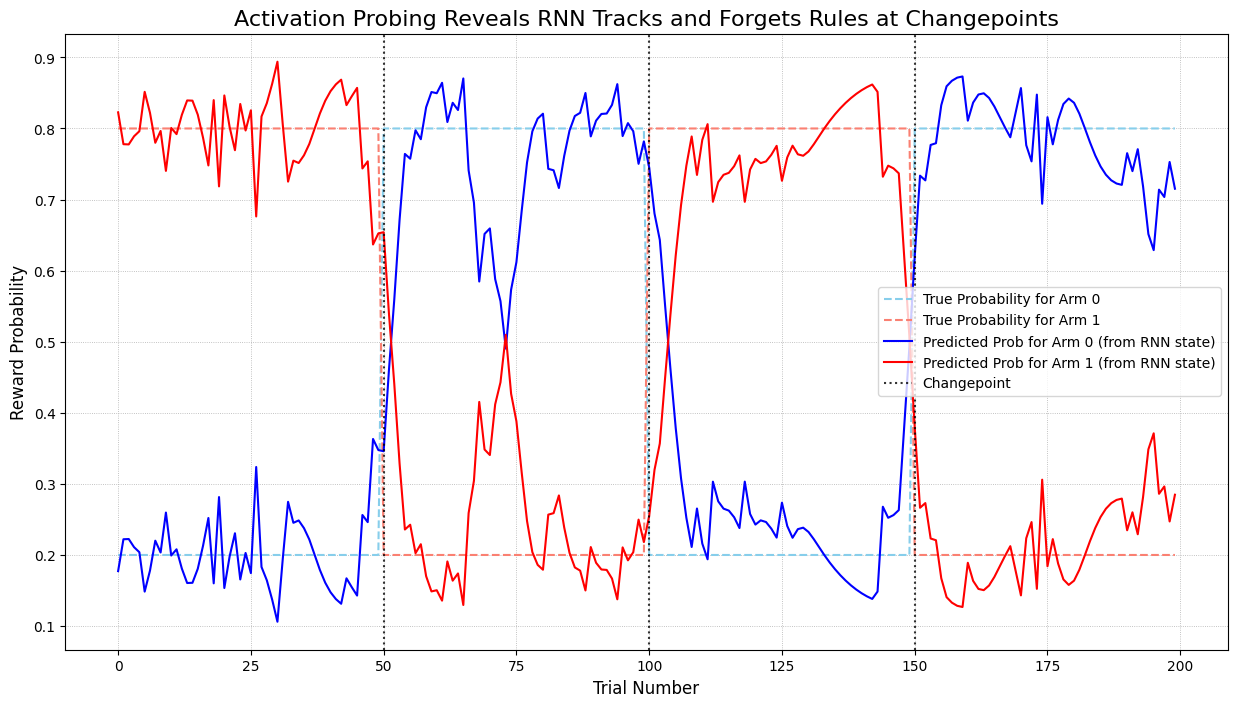

In [5]:

# ### PART 4: MAIN EXECUTION SCRIPT ###

if __name__ == '__main__':
    # Building the Meta-RL agent and its optimizer
    meta_rl_agent = MetaRLAgent()
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 1. Training the agent using the 2019 project's method
    trained_agent = train_meta_rl_agent(meta_rl_agent, optimizer, n_episodes=3000)

    # 2. Running the 2022 project's experiment on the trained agent
    probe_and_plot_activations(trained_agent)

**Conclusion**

The solid lines (the predictions from your "mind-reading" probe) are doing a great job of tracking the dashed lines (the ground truth). This confirms our first hypothesis: the RNN's internal memory state (its "brain activity") is actively representing its belief about the current reward probabilities of the world.

We can also observe that at Trial 50, the mission suddenly changes. We can see how the solid red and blue lines rapidly jump to their new correct values. They don't slowly drift, they make a sharp, decisive switch.The same thing is happening at Trial 100, Trial 150, Trial 200. This is the visual evidence of adaptive forgetting.

Thus we can say that,
- during stable periods: it integrates information to maintain a steady belief about the environment.
- when a major changepoint occurs: It rapidly discards, or "forgets," its old beliefs and starts fresh, allowing it to adapt almost instantly to the new rules.